In [3]:
import dask
dask.config.set({"dataframe.query-planning": True})
import pandas

In [4]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [5]:
import itertools
import pandas as pd
import numpy as np
from random import gauss,shuffle

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

'''
het_arch - (ARCH Test)
Purpose: Tests for Autoregressive Conditional Heteroskedasticity (ARCH) effects in the residuals of a time series model.
Usage: Helps detect volatility clustering (common in financial time series).
Null Hypothesis (H₀): No ARCH effects (residuals are homoskedastic).
Alternative Hypothesis (H₁): ARCH effects exist (residuals are heteroskedastic).
Output: Test statistic and p-value. If p-value < significance level (e.g., 0.05), reject H₀.

 (Ljung-Box Test)
Purpose: Tests whether autocorrelations in the residuals of a time series model are zero (no serial correlation).
Usage: Checks for remaining structure in residuals after fitting a model (e.g., ARIMA).
Null Hypothesis (H₀): No autocorrelation up to lag lags.
Alternative Hypothesis (H₁): Autocorrelation exists.
Output: Test statistic and p-value for each lag. Small p-values indicate significant autocorrelation.
'''

from sklearn.metrics import mean_absolute_error as mae ,mean_absolute_percentage_error as mape ,mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os
# import lightgbm as lgb

from datetime import datetime, timedelta
import gc,copy

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.filterwarnings("ignore")

In [6]:
#Adjust displayed images size
plt.rcParams.update({'figure.figsize':(20,10)})

In [7]:
# pip install --upgrade jupyter

In [8]:
df=pd.read_csv("C:/Users/bhara/Downloads/m5-forecasting-accuracy/sales_train_validation.csv")
df = df.loc[df.state_id == 'CA']
df.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


df = reduce_mem_usage(df)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [10]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

# UnPivotting

In [12]:
df = pd.melt(df,id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],var_name="d",value_name="Sales").dropna()

In [13]:
df.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d,Sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [14]:
cal = pd.read_csv("C:/Users/bhara/Downloads/m5-forecasting-accuracy/calendar.csv")

In [15]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [16]:
df=pd.merge(df,cal,on="d",how='left')
del cal

In [17]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'Sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [18]:
df.drop(['d','wm_yr_wk', 'weekday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI'],axis=1,inplace=True)

In [19]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0


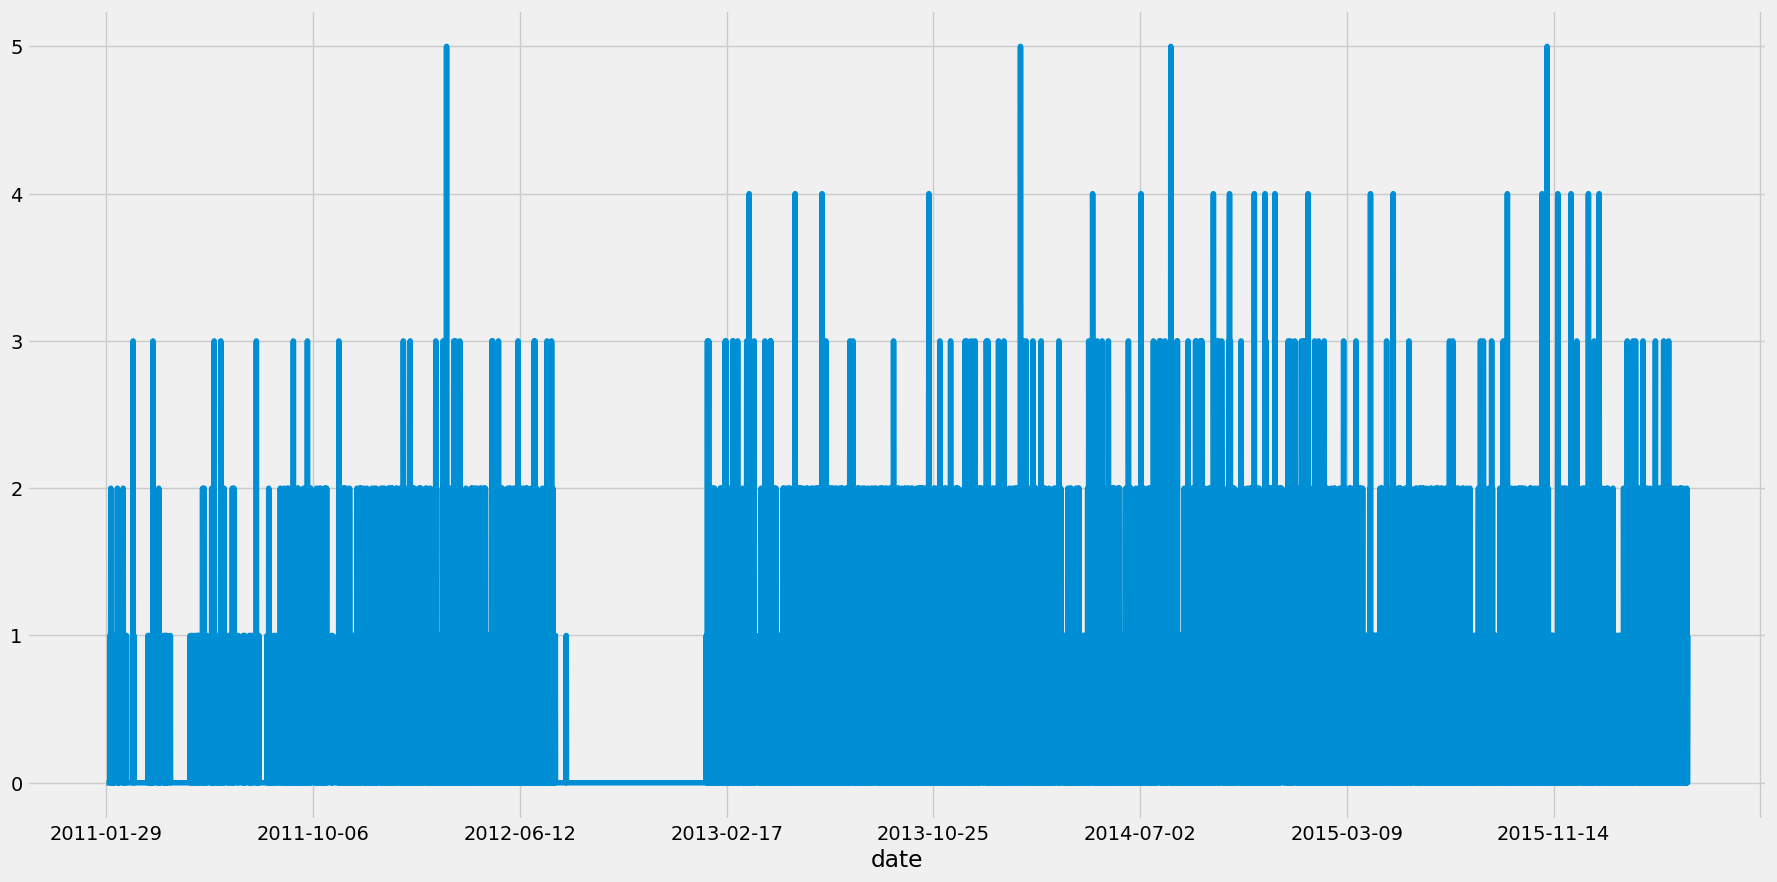

In [20]:
df1 = df.loc[df['item_id']=='HOBBIES_1_195'][['date','Sales']].copy()
df1.set_index("date").Sales.plot()
plt.show()

# Generate Features to convert into a reg based FC

In [22]:
df["Lag_28"] = df[["id","Sales"]].groupby("id")["Sales"].shift(28).fillna(-1)

In [23]:
df[df["id"]=="HOBBIES_1_001_CA_1_validation"].tail()

,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,wday,snap_CA,Lag_28
23269968,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,2016-04-20,5,0,2.0
23282164,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,3,2016-04-21,6,0,0.0
23294360,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2016-04-22,7,0,1.0
23306556,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,2016-04-23,1,0,1.0
23318752,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,2016-04-24,2,0,1.0


In [25]:
df["rmean_7_lag28"]=df[["id","Lag_28"]].groupby("id")["Lag_28"].transform(lambda x:x.rolling(7).mean()).fillna(-1)
df["rmean_28_lag28"]=df[["id","Lag_28"]].groupby("id")["Lag_28"].transform(lambda x:x.rolling(28).mean()).fillna(-1)

In [26]:
df.tail(10)

,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,wday,snap_CA,Lag_28,rmean_7_lag28,rmean_28_lag28
23330938,FOODS_3_818_CA_4_validation,FOODS_3_818,FOODS_3,FOODS,CA_4,CA,5,2016-04-24,2,0,1.0,3.000000,3.500000
23330939,FOODS_3_819_CA_4_validation,FOODS_3_819,FOODS_3,FOODS,CA_4,CA,0,2016-04-24,2,0,2.0,0.714286,0.535714
23330940,FOODS_3_820_CA_4_validation,FOODS_3_820,FOODS_3,FOODS,CA_4,CA,3,2016-04-24,2,0,1.0,0.714286,1.000000
23330941,FOODS_3_821_CA_4_validation,FOODS_3_821,FOODS_3,FOODS,CA_4,CA,0,2016-04-24,2,0,0.0,0.571429,0.428571
23330942,FOODS_3_822_CA_4_validation,FOODS_3_822,FOODS_3,FOODS,CA_4,CA,2,2016-04-24,2,0,0.0,0.571429,0.642857
23330943,FOODS_3_823_CA_4_validation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,0,2016-04-24,2,0,0.0,0.000000,0.607143
23330944,FOODS_3_824_CA_4_validation,FOODS_3_824,FOODS_3,FOODS,CA_4,CA,1,2016-04-24,2,0,0.0,0.000000,0.000000
23330945,FOODS_3_825_CA_4_validation,FOODS_3_825,FOODS_3,FOODS,CA_4,CA,0,2016-04-24,2,0,0.0,0.285714,0.642857
23330946,FOODS_3_826_CA_4_validation,FOODS_3_826,FOODS_3,FOODS,CA_4,CA,4,2016-04-24,2,0,2.0,1.857143,2.107143
23330947,FOODS_3_827_CA_4_validation,FOODS_3_827,FOODS_3,FOODS,CA_4,CA,8,2016-04-24,2,0,0.0,1.000000,0.857143


In [27]:
df[df["id"]=="FOODS_1_001_CA_1_validation"].head(35)

,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,wday,snap_CA,Lag_28,rmean_7_lag28,rmean_28_lag28
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,1,0,-1.0,-1.000000,-1.000000
13808,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,2,0,-1.0,-1.000000,-1.000000
26004,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,3,0,-1.0,-1.000000,-1.000000
38200,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,4,1,-1.0,-1.000000,-1.000000
50396,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,5,1,-1.0,-1.000000,-1.000000
62592,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,2011-02-03,6,1,-1.0,-1.000000,-1.000000
74788,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-02-04,7,1,-1.0,-1.000000,-1.000000
86984,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,2011-02-05,1,1,-1.0,-1.000000,-1.000000
99180,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-02-06,2,1,-1.0,-1.000000,-1.000000
111376,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-02-07,3,1,-1.0,-1.000000,-1.000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23330948 entries, 0 to 23330947
Data columns (total 13 columns):
 #   Column          Dtype   
---  ------          -----   
 0   id              category
 1   item_id         category
 2   dept_id         category
 3   cat_id          category
 4   store_id        category
 5   state_id        category
 6   Sales           int16   
 7   date            object  
 8   wday            int64   
 9   snap_CA         int64   
 10  Lag_28          float64 
 11  rmean_7_lag28   float64 
 12  rmean_28_lag28  float64 
dtypes: category(6), float64(3), int16(1), int64(2), object(1)
memory usage: 1.3+ GB


In [29]:
df["date"]=pd.to_datetime(df["date"])

In [30]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,wday,snap_CA,Lag_28,rmean_7_lag28,rmean_28_lag28
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0


In [31]:
date_feats = {

    "wday":"weekday",
    "month":"month",
    "quarter":"quarter",
    "year":"year",
    "mday":"day"
}

for col_name,func_name in date_feats.items():
    if col_name in df.columns:
        df[col_name]=df[col_name].astype("int16")
    else:
        df[col_name] = getattr(df["date"].dt,func_name).astype("int16")

In [33]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,wday,snap_CA,Lag_28,rmean_7_lag28,rmean_28_lag28,month,quarter,year,mday
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29


In [34]:
df["WeekNum"] = df["date"].dt.isocalendar().week

In [35]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,wday,snap_CA,Lag_28,rmean_7_lag28,rmean_28_lag28,month,quarter,year,mday,WeekNum
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29,4
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29,4
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29,4
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29,4
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,1,0,-1.0,-1.0,-1.0,1,1,2011,29,4


In [36]:
df1=df.copy()

In [37]:
cat_items = [cols for cols in df.columns if df[cols].dtype == "category"]
cat_items

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [38]:
cat_items.remove("id")

In [39]:
cat_items

['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [40]:
le=LabelEncoder()
lemap={}
dic={}
for cc in cat_items:
    df1[cc]=le.fit_transform(df1[cc])
    lemap[cc] = {label: encoded for encoded, label in enumerate(le.classes_)}
    

In [41]:
lemap

{'item_id': {'FOODS_1_001': 0,
  'FOODS_1_002': 1,
  'FOODS_1_003': 2,
  'FOODS_1_004': 3,
  'FOODS_1_005': 4,
  'FOODS_1_006': 5,
  'FOODS_1_008': 6,
  'FOODS_1_009': 7,
  'FOODS_1_010': 8,
  'FOODS_1_011': 9,
  'FOODS_1_012': 10,
  'FOODS_1_013': 11,
  'FOODS_1_014': 12,
  'FOODS_1_015': 13,
  'FOODS_1_016': 14,
  'FOODS_1_017': 15,
  'FOODS_1_018': 16,
  'FOODS_1_019': 17,
  'FOODS_1_020': 18,
  'FOODS_1_021': 19,
  'FOODS_1_022': 20,
  'FOODS_1_023': 21,
  'FOODS_1_024': 22,
  'FOODS_1_025': 23,
  'FOODS_1_026': 24,
  'FOODS_1_027': 25,
  'FOODS_1_028': 26,
  'FOODS_1_029': 27,
  'FOODS_1_030': 28,
  'FOODS_1_031': 29,
  'FOODS_1_032': 30,
  'FOODS_1_033': 31,
  'FOODS_1_034': 32,
  'FOODS_1_035': 33,
  'FOODS_1_036': 34,
  'FOODS_1_037': 35,
  'FOODS_1_038': 36,
  'FOODS_1_039': 37,
  'FOODS_1_040': 38,
  'FOODS_1_041': 39,
  'FOODS_1_042': 40,
  'FOODS_1_043': 41,
  'FOODS_1_044': 42,
  'FOODS_1_045': 43,
  'FOODS_1_046': 44,
  'FOODS_1_047': 45,
  'FOODS_1_048': 46,
  'FOODS_1_0

In [42]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'Sales',
       'date', 'wday', 'snap_CA', 'Lag_28', 'rmean_7_lag28', 'rmean_28_lag28',
       'month', 'quarter', 'year', 'mday', 'WeekNum'],
      dtype='object')

In [43]:
cutoffdate = df["date"].max()-pd.to_timedelta(28,unit="D")
cutoffdate

Timestamp('2016-03-27 00:00:00')

In [44]:
Xtrain = df.loc[df.date < cutoffdate].copy()
Xtest = df.loc[df.date >= cutoffdate].copy()

In [45]:
Xtest.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,Sales,date,wday,snap_CA,Lag_28,rmean_7_lag28,rmean_28_lag28,month,quarter,year,mday,WeekNum
22977264,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,2016-03-27,2,0,2.0,1.714286,1.035714,3,1,2016,27,12
22977265,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,2016-03-27,2,0,0.0,0.142857,0.178571,3,1,2016,27,12


In [46]:
ytrain = Xtrain['Sales'].copy()
ytest = Xtest['Sales'].copy()

In [47]:
ytrain

0           0
1           0
2           0
3           0
4           0
           ..
22977259    0
22977260    0
22977261    0
22977262    2
22977263    1
Name: Sales, Length: 22977264, dtype: int16

## Reason we separately create dtrain and dvalid as LightGBM Dataset objects (instead of using the raw DataFrames xtrain/xvalid directly) is because LightGBM requires its own optimized data structure for efficient training. Here's why this is necessary:

Key Reasons for Using lgb.Dataset
Memory Optimization
LightGBM converts the data into a binarized format (histograms) for faster operations. The Dataset object stores this optimized representation.

Preprocessing
The dataset object handles:

Automatic handling of categorical features

Missing value treatment

Optimal memory layout for the boosting algorithm

Validation Tracking
The dvalid dataset enables proper validation during training (early stopping, metric evaluation).

In [49]:
Xtrain.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'Sales',
       'date', 'wday', 'snap_CA', 'Lag_28', 'rmean_7_lag28', 'rmean_28_lag28',
       'month', 'quarter', 'year', 'mday', 'WeekNum'],
      dtype='object')

In [50]:
Xtrain.drop(['id', 'wday', 'Sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)
Xtest.drop(['id', 'wday', 'Sales',  'snap_CA', 'year', 'date'], axis = 1, inplace = True)

In [51]:
lgbXtrain = lgb.Dataset(Xtrain,label = ytrain, free_raw_data=False)
lgbXtest = lgb.Dataset(Xtrain,label = ytest, free_raw_data=False)

In [52]:
ytrain

0           0
1           0
2           0
3           0
4           0
           ..
22977259    0
22977260    0
22977261    0
22977262    2
22977263    1
Name: Sales, Length: 22977264, dtype: int16

In [53]:
import seaborn as sns

In [99]:
params = {
     "objective" : "poisson",
        "metric" : "rmse",
        "learning_rate" : 0.075,
         "feature_fraction" : 0.8,
        "bagging_fraction" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 1000,        
        'num_leaves': 64,
        "min_data_in_leaf": 100,
}

In [110]:
from lightgbm import LGBMRegressor

In [112]:
m_lgb = LGBMRegressor(**params)

In [118]:
m_lgb.fit(Xtrain,ytrain,eval_set=[(Xtest,ytest)],callbacks=[lgb.early_stopping(stopping_rounds=100)])

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree

LGBMRegressor(bagging_fraction=0.75, bagging_freq=1, feature_fraction=0.8,
              lambda_l2=0.1, learning_rate=0.075, metric='rmse',
              min_data_in_leaf=100, num_iterations=1000, num_leaves=64,
              objective='poisson', verbosity=1)

In [120]:
m_lgb.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('rmse', 2.2855327495461117)])})

In [122]:
m_lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.075,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 64,
 'objective': 'poisson',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse',
 'feature_fraction': 0.8,
 'bagging_fraction': 0.75,
 'bagging_freq': 1,
 'lambda_l2': 0.1,
 'verbosity': 1,
 'num_iterations': 1000,
 'min_data_in_leaf': 100}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

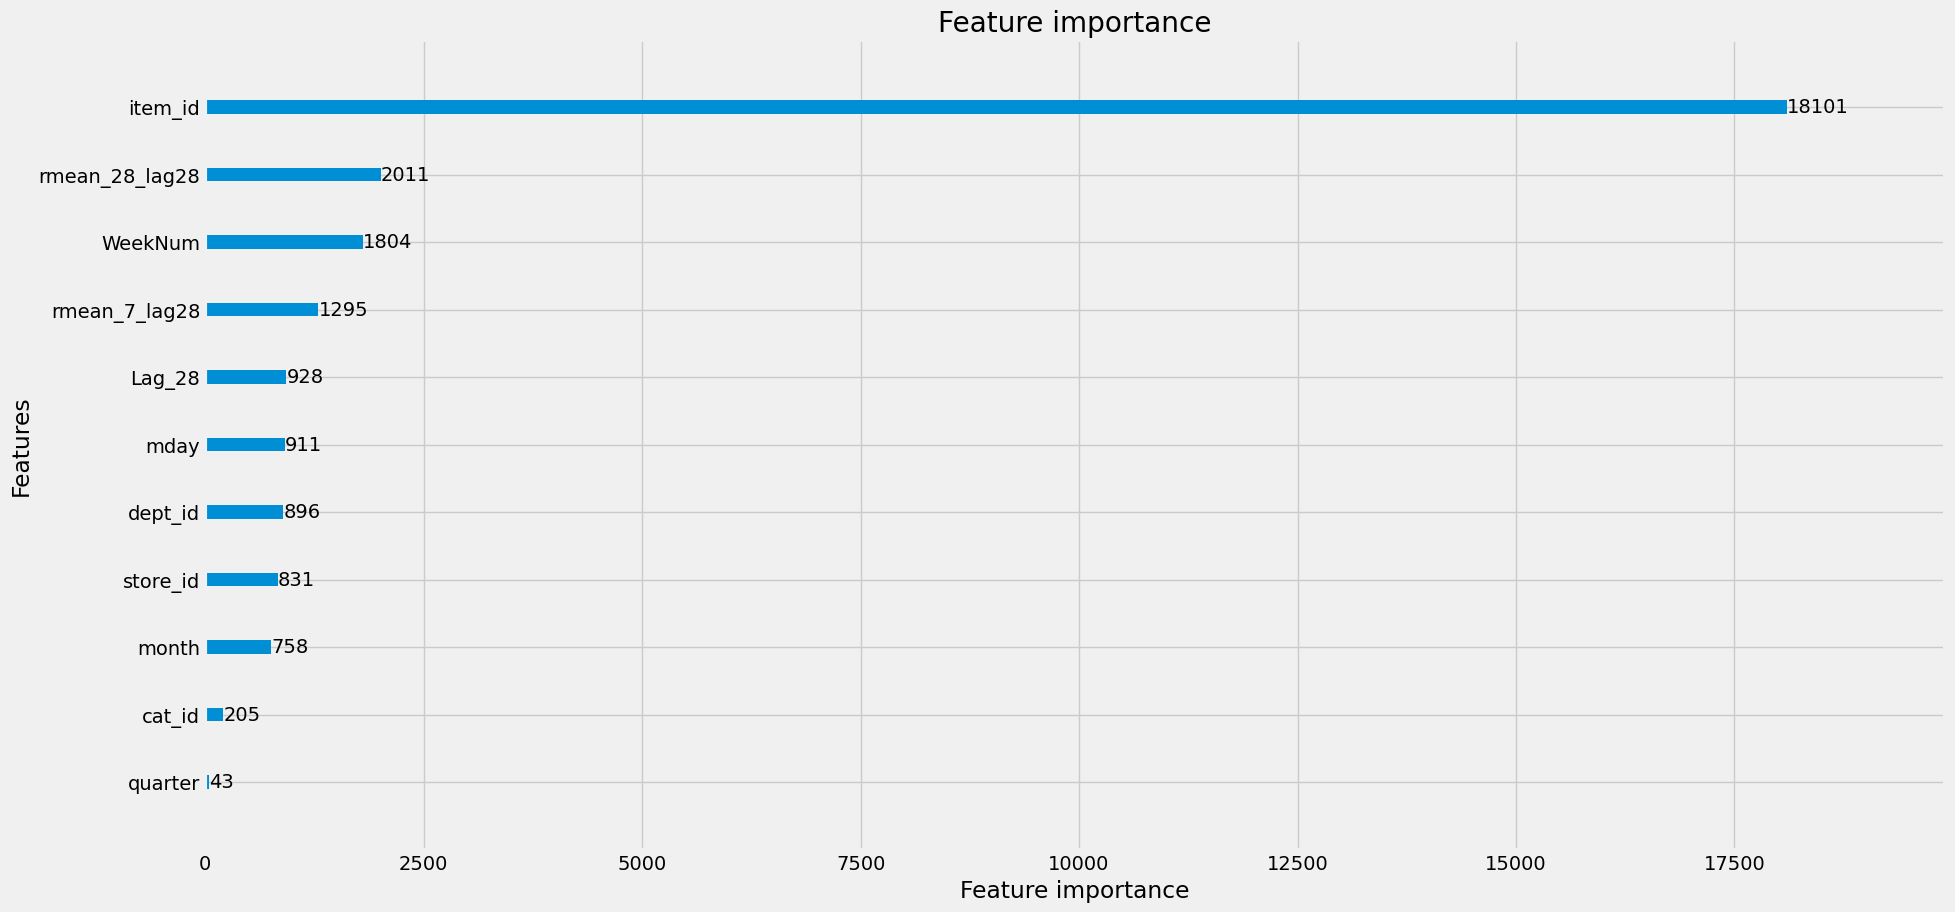

In [126]:
lgb.plot_importance(m_lgb)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

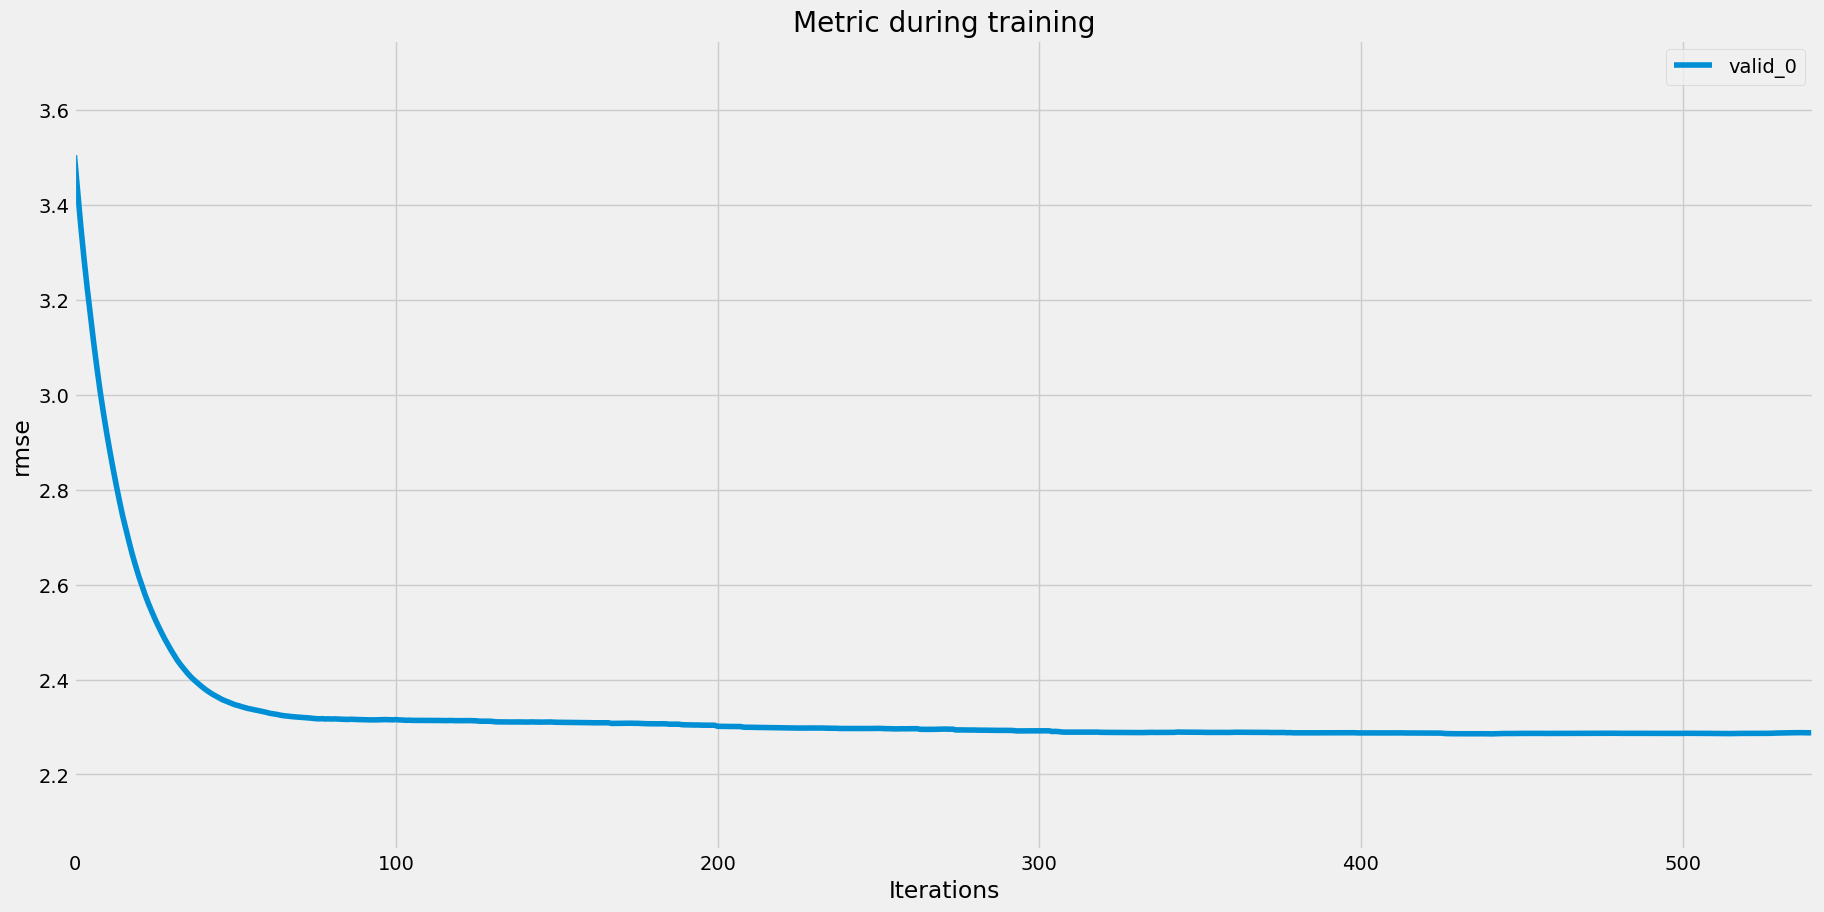

In [128]:
lgb.plot_metric(m_lgb)

<Axes: title={'center': 'Split value histogram for feature with name month'}, xlabel='Feature split value', ylabel='Count'>

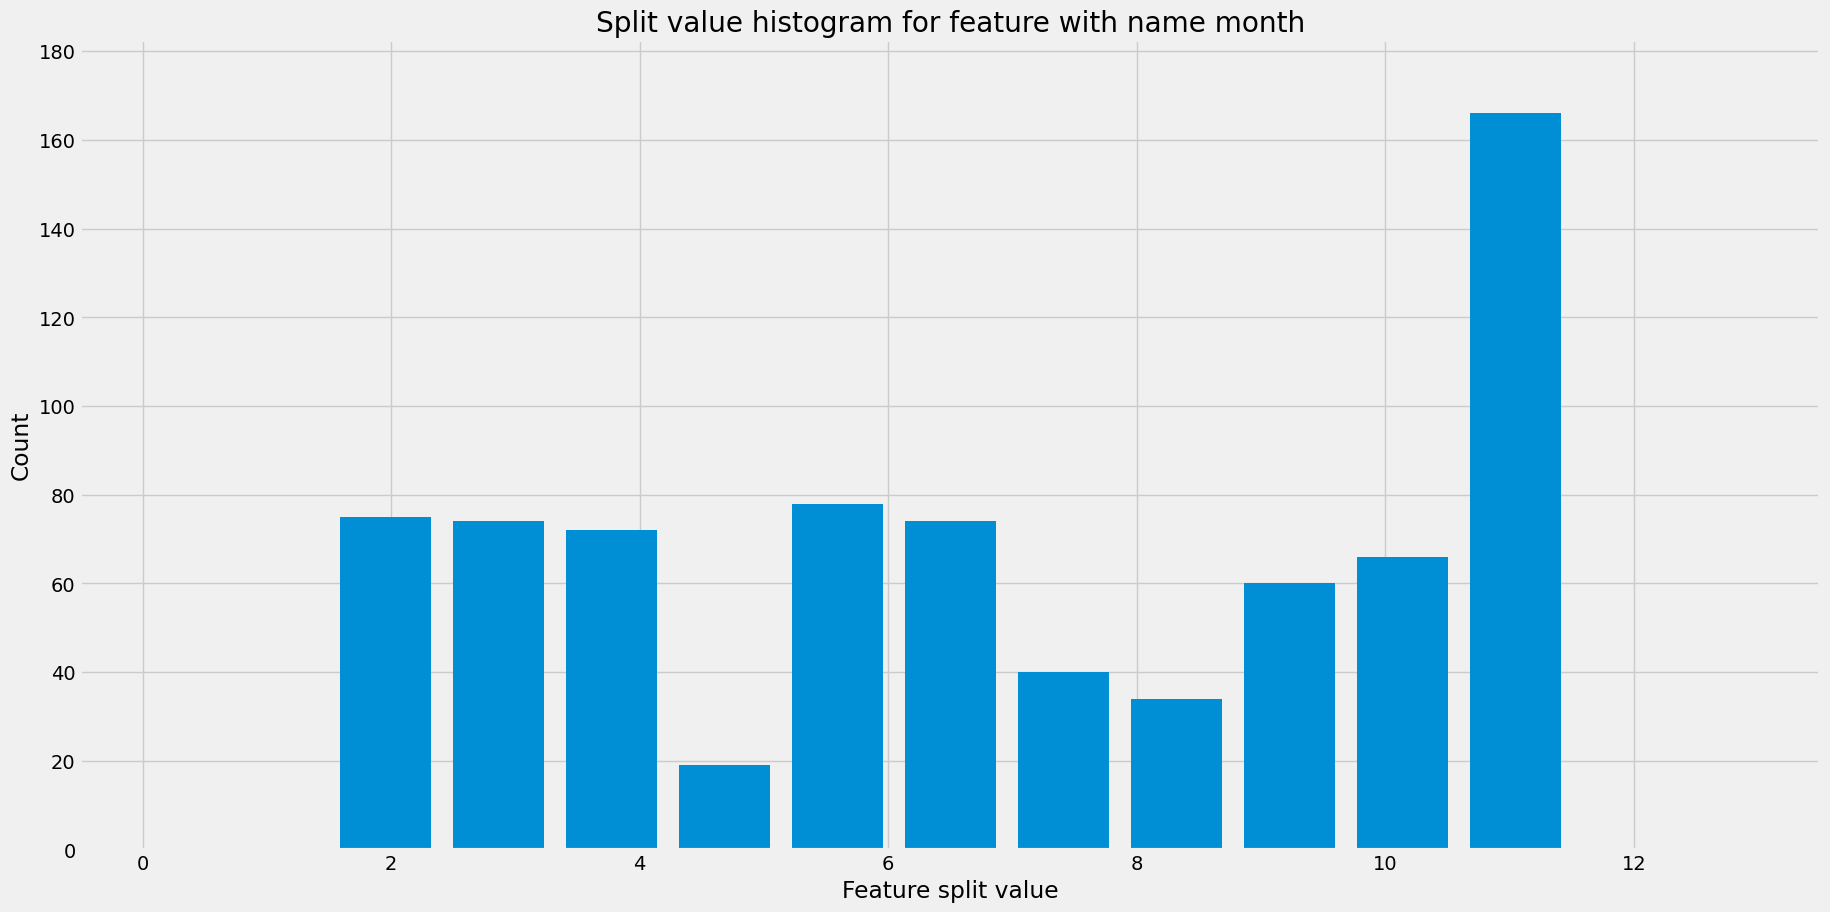

In [136]:
lgb.plot_split_value_histogram(m_lgb,feature='month')